In [330]:
# Importing all required modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm, shapiro

In [248]:
df = pd.read_csv("walmart_data.csv")
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,7969


In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User_ID                     550068 non-null  int64 
 1   Product_ID                  550068 non-null  object
 2   Gender                      550068 non-null  object
 3   Age                         550068 non-null  object
 4   Occupation                  550068 non-null  int64 
 5   City_Category               550068 non-null  object
 6   Stay_In_Current_City_Years  550068 non-null  object
 7   Marital_Status              550068 non-null  int64 
 8   Product_Category            550068 non-null  int64 
 9   Purchase                    550068 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 42.0+ MB


In [250]:
# Checking for unique values for Stay_In_Current_City_Years
df["Stay_In_Current_City_Years"].unique()

array(['2', '4+', '3', '1', '0'], dtype=object)

In [251]:
# Converting User_ID, Occupation, Product_Category, City_Category and Age_Category to categorical datatype since we don't need to perform any numerical operations on them
df["User_ID"] = df["User_ID"].astype("category")
df["Occupation"] = df["Occupation"].astype("category")
df["Age"] = df["Age"].astype("category")
df["City_Category"] = df["City_Category"].astype("category")
df["Stay_In_Current_City_Years"] = df["Stay_In_Current_City_Years"].astype(
    "category")
df["Product_Category"] = df["Product_Category"].astype("category")

# Converting Marital_Status to type Boolean
df["Marital_Status"] = df["Marital_Status"].astype("bool")
df.dtypes

User_ID                       category
Product_ID                      object
Gender                          object
Age                           category
Occupation                    category
City_Category                 category
Stay_In_Current_City_Years    category
Marital_Status                    bool
Product_Category              category
Purchase                         int64
dtype: object

In [252]:
# Checking if there are any null values to handle
df.isnull().values.any()

False

In [253]:
# Counting the number of unique Independent Variables
print("Total Unique Users: ", df["User_ID"].nunique())
print("Total Unique Age-groups: ", df["Age"].nunique())
print("Total Unique Occupation categories: ", df["Occupation"].nunique())
print("Total Unique Products Categories: ", df["Product_Category"].nunique())
print("Total Unique City Categories: ", df["City_Category"].nunique())

Total Unique Users:  5891
Total Unique Age-groups:  7
Total Unique Occupation categories:  21
Total Unique Products Categories:  20
Total Unique City Categories:  3


In [254]:
# Checking for the number of rows and overall shape of the dataset
df.shape

(550068, 10)

> There are over 550,000 non-null records available in the walmart dataset for 5891 unique users.

In [255]:
# We'll clip and keep only the data which has a purchase value between 5-95 percentile of Purchase.
purchase_lower_limit = math.floor(np.percentile(df["Purchase"].unique(), 5))
purchase_upper_limit = math.floor(np.percentile(df["Purchase"].unique(), 95))
purchase_mask = np.clip(df["Purchase"].unique(), purchase_lower_limit, purchase_upper_limit)
df = df[df["Purchase"].isin(purchase_mask)]
df.shape

(527860, 10)

> After clipping the data, we now have ~528,000 entries to work with.

In [256]:
# Creating a separate dataframe to capture the number of visits by each User ID
purchase_count_df = df["User_ID"].value_counts().to_frame().reset_index()
purchase_count_df.rename(columns={"count":"Total_Purchases"}, inplace=True)
purchase_count_df

,User_ID,Total_Purchases
0,1001680,986
1,1004277,953
2,1001941,838
3,1001181,827
4,1000889,786
...,...,...
5886,1005608,6
5887,1005391,6
5888,1005810,6
5889,1004464,6


In [257]:
# Merging the visit_count_df with the original df
df = pd.merge(df, purchase_count_df, how="left", on="User_ID")
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category,Purchase,Total_Purchases
0,1000001,P00069042,F,0-17,10,A,2,False,3,8370,31
1,1000001,P00248942,F,0-17,10,A,2,False,1,15200,31
2,1000002,P00285442,M,55+,16,C,4+,False,8,7969,76
3,1000003,P00193542,M,26-35,15,A,3,False,1,15227,29
4,1000004,P00184942,M,46-50,7,B,2,True,1,19215,13


<Axes: xlabel='Age', ylabel='Purchase'>

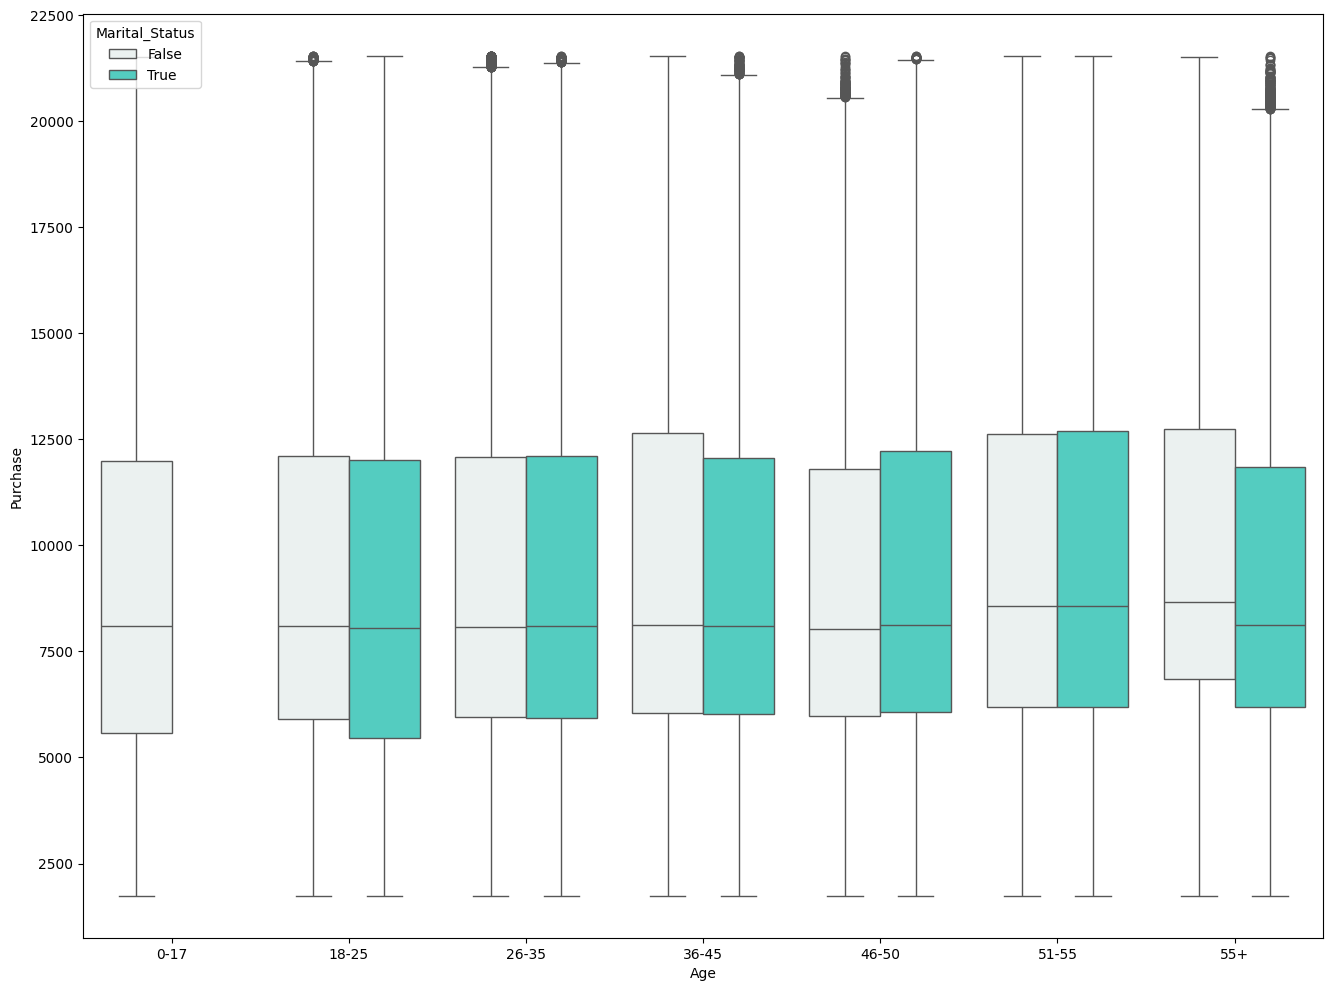

In [266]:
fig, axes = plt.subplots(1, 1, figsize=(16, 12))
sns.boxplot(data=df, x="Age", y="Purchase",
            hue="Marital_Status", palette="light:turquoise")

> Looking at the above plot, we see that on average, the most purcahse (amount wise) made are by customers belonging to the age group 55+ who are unmarried. We also see that we numerous outliers which go beyond the top whiskers which means the overall distribution is **right skewed**.

In [273]:
# Gender-wise total Purchase comparison
df.groupby("Gender").Purchase.sum()

Gender
F    1168169116
M    3852430358
Name: Purchase, dtype: int64

In [274]:
3852430358/df["Purchase"].sum()

0.7673247742526453

> In the given sample, Males account for about 77% of Purchases made compared to women. Hence, providing more revenue to Walmart (as per the available sample)

<Axes: xlabel='Age', ylabel='Purchase'>

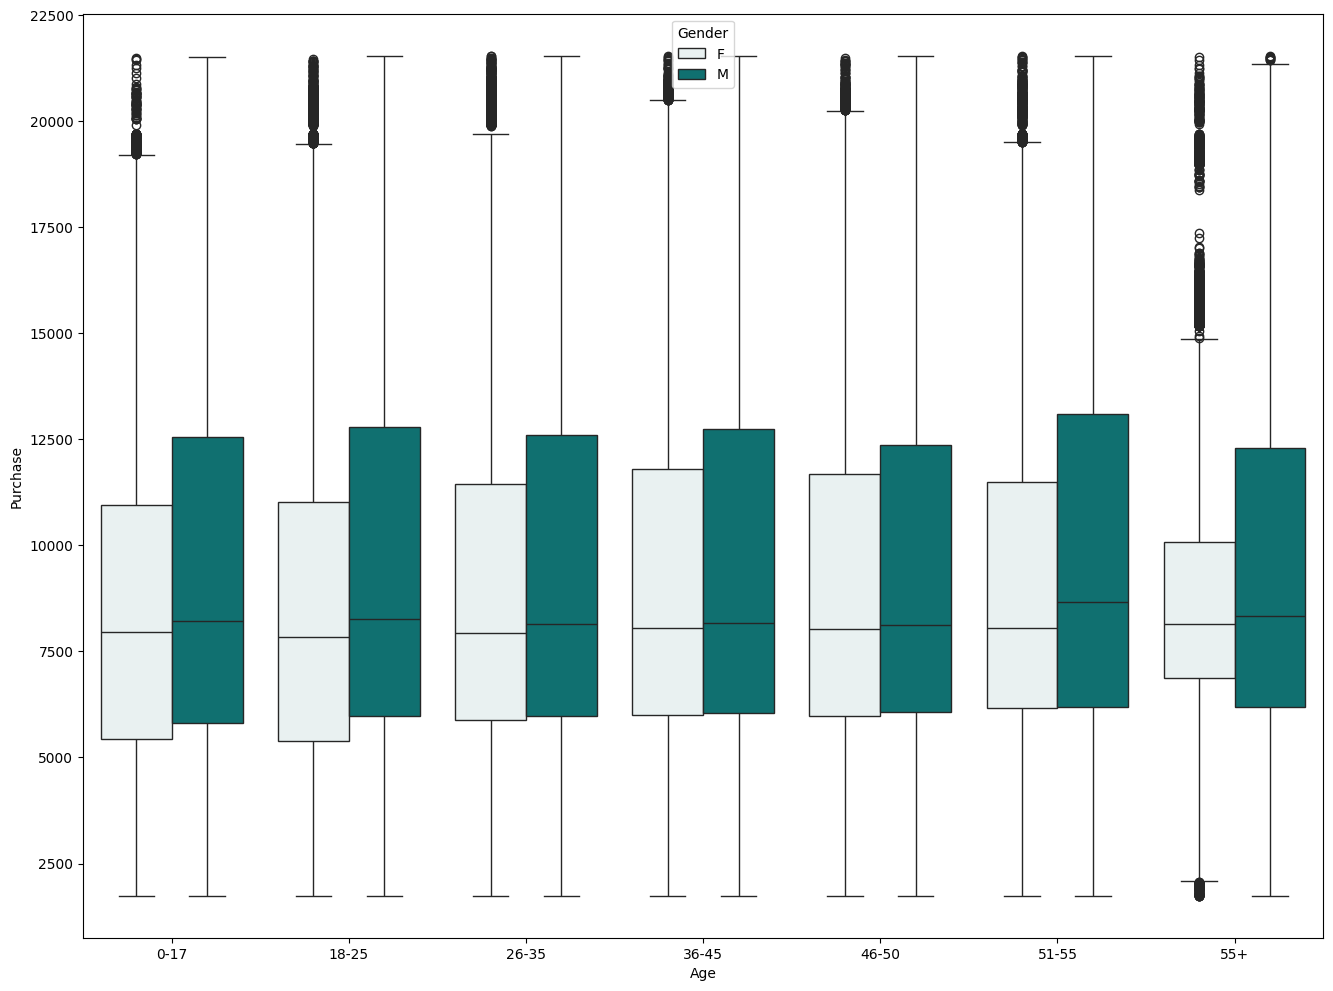

In [262]:
fig, axes = plt.subplots(1, 1, figsize=(16, 12))
sns.boxplot(data=df, x="Age", y="Purchase",
            hue="Gender", palette="light:teal")

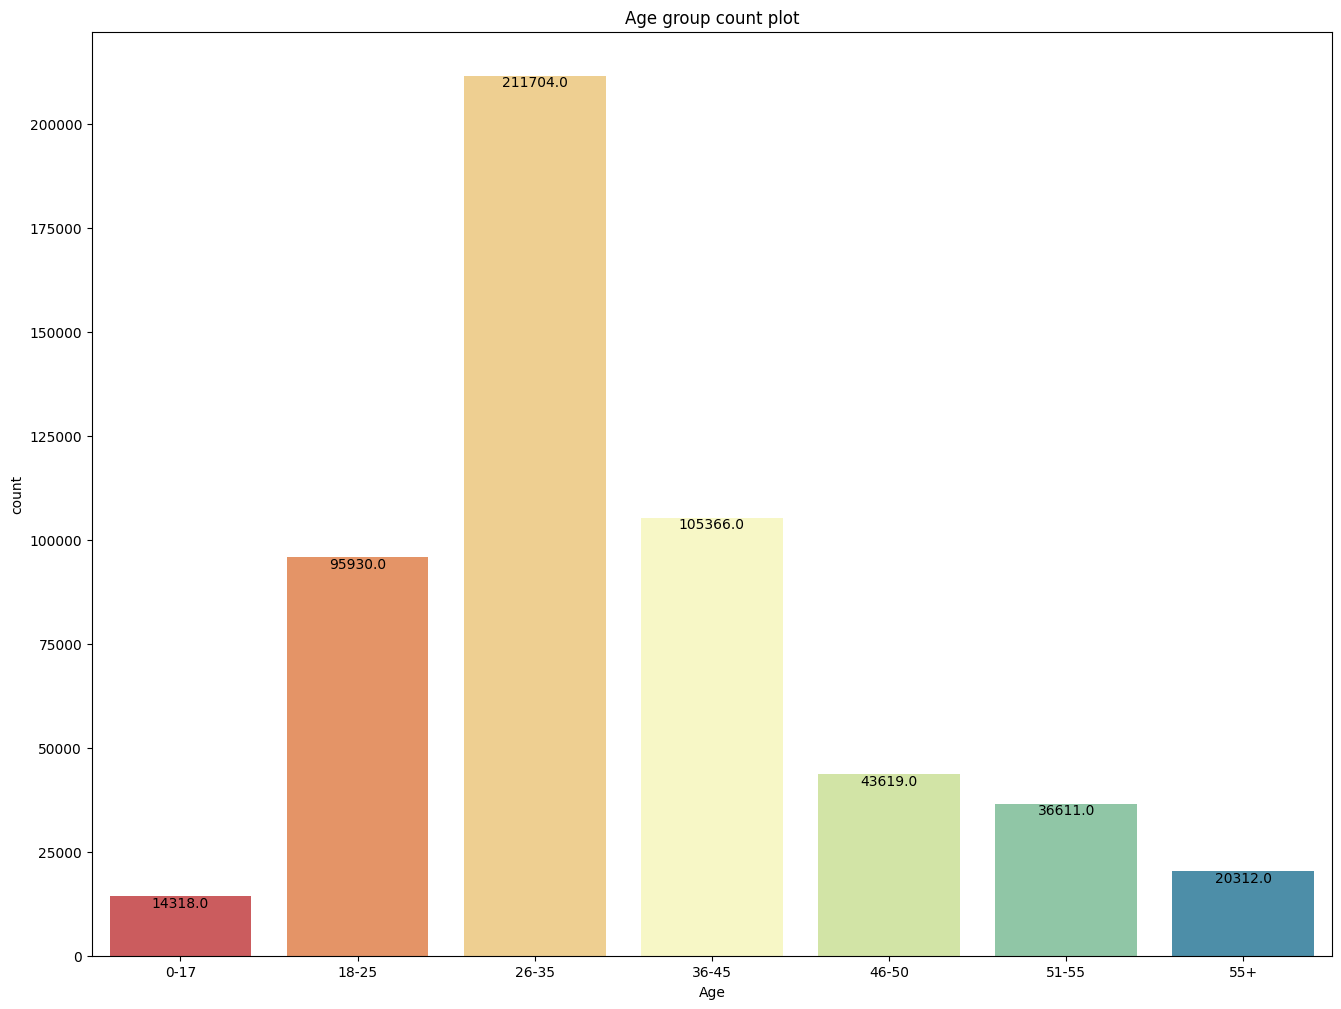

In [208]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(1, 1, figsize=(16,12))
axe = sns.countplot(ax=ax1, data=df,
                    x="Age", hue="Age", palette="Spectral")
ax1.title.set_text('Age group count plot')

for patch in axe.patches:
    axe.annotate(patch.get_height(), (patch.get_x()+0.4,
                 patch.get_height()+4), ha='center', va='top')

> From the above plot, we see that the customers belonging to age group 26 to 35 at the highest purchase count

<Axes: xlabel='Product_Category', ylabel='count'>

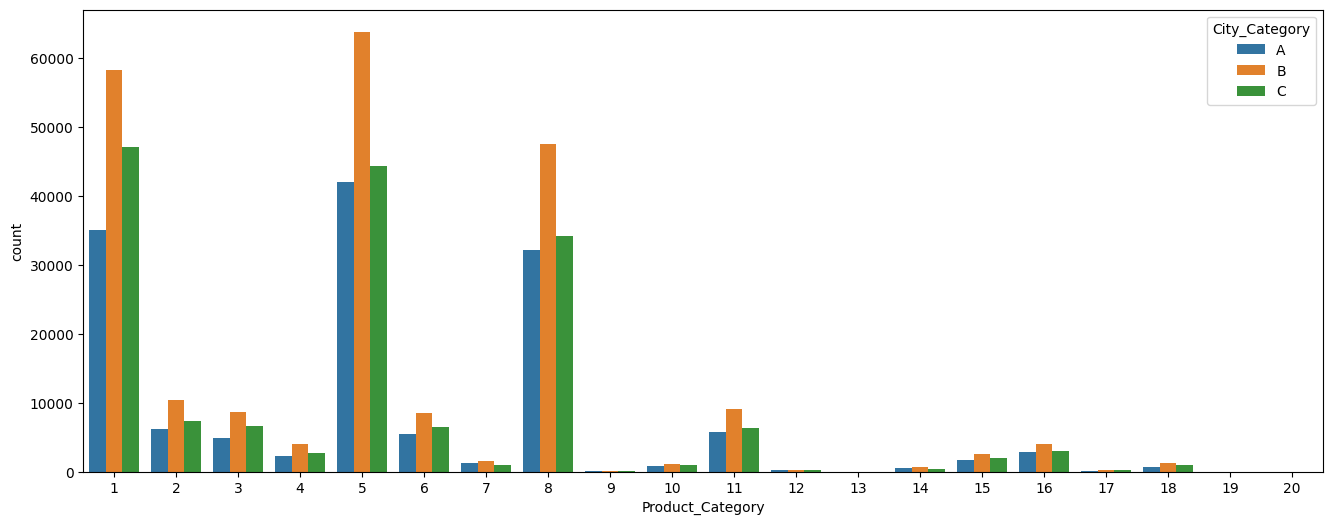

In [209]:
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
sns.countplot(data=df, x="Product_Category", hue="City_Category")

> From the above plot we see that customers belonging to City Category "B" buy the highest count of products belonging to product category 5, 1 and 8.

<Axes: xlabel='Product_Category', ylabel='count'>

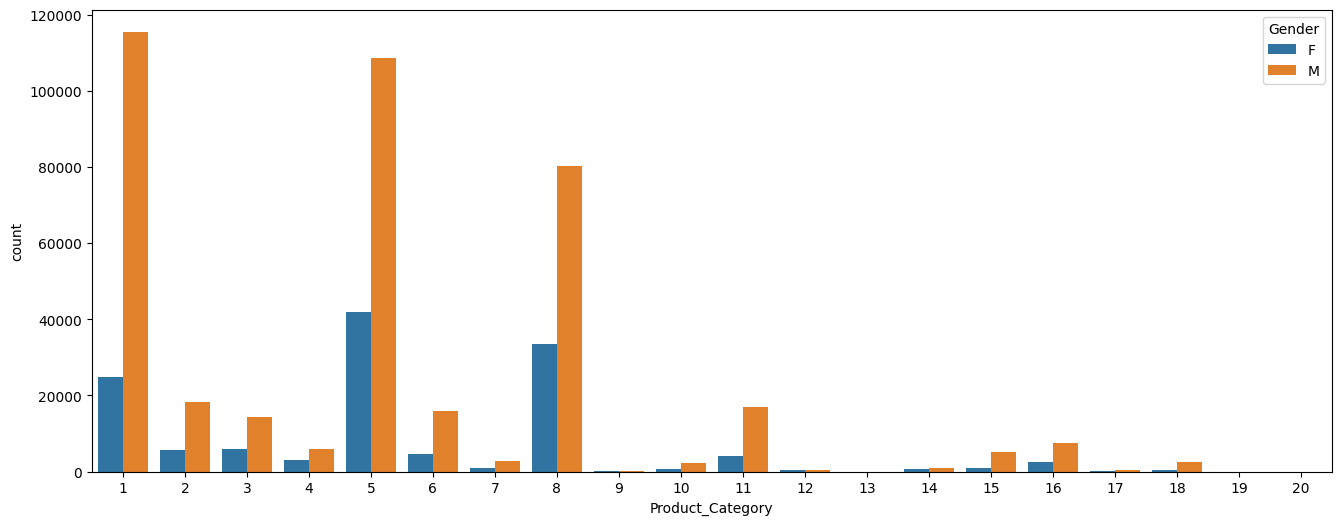

In [210]:
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
sns.countplot(df[["Gender", "Product_Category"]], x="Product_Category", hue="Gender")

> Most preferred Product Category for **Males** are 1 > 5 > 8 and for **Females**: 5 > 8 > 1

In [275]:
# Since we need to compute the confidence interval of different sample sizes - 300, 3000, and 30000, we'll write a small function to encapsulate the sample means which is required for applying CLT.
def generate_purchase_means_from_samples(df:pd.DataFrame, sample_size:int):
    purchase_means = []
    for _ in range(1000):
        sample_df = df.sample(sample_size)
        purchase_mean = sample_df["Purchase"].mean()
        purchase_means.append(purchase_mean)
    return purchase_means

### Conditions to fulfill to apply CLT
- Sample size should be greater than 30
- Distribution of Sample means should be a normal distribution (Gaussian)
- The means of sample should be approx. close to the populations mean

> Hence, we will need to check if the samples satisfies the aforementioned conditions

***Analysis of Purchases over Gender Category with a Sample size of 300***

In [276]:
male_df = df[df["Gender"] == "M"]
female_df = df[df["Gender"] == "F"]

# Gender-wise purchase sample of 300
male_sample_means_300 = generate_purchase_means_from_samples(male_df, 300)
female_sample_means_300 = generate_purchase_means_from_samples(female_df, 300)

Male population mean:  9678.938244619645
Male Sample mean:  9678.938244619645
Female population mean:  8997.128082687657
Female Sample mean:  8997.128082687657


In [277]:
# Sample Purchase means comparison with population mean
print("Male population mean: ", male_df["Purchase"].mean())
print("Male Sample mean: ", np.mean(male_sample_means_300))
print("Female population mean: ", female_df["Purchase"].mean())
print("Female Sample mean: ", np.mean(female_sample_means_300))

Male population mean:  9678.938244619645
Male Sample mean:  9680.874189999999
Female population mean:  8997.128082687657
Female Sample mean:  8993.980963333332


> The above comparison of population and sample means satisfies the condition: ***The means of sample should be approx. close to the populations mean***

Now we check if it satifies the second condition of the sample means displaying a Gaussian distribution

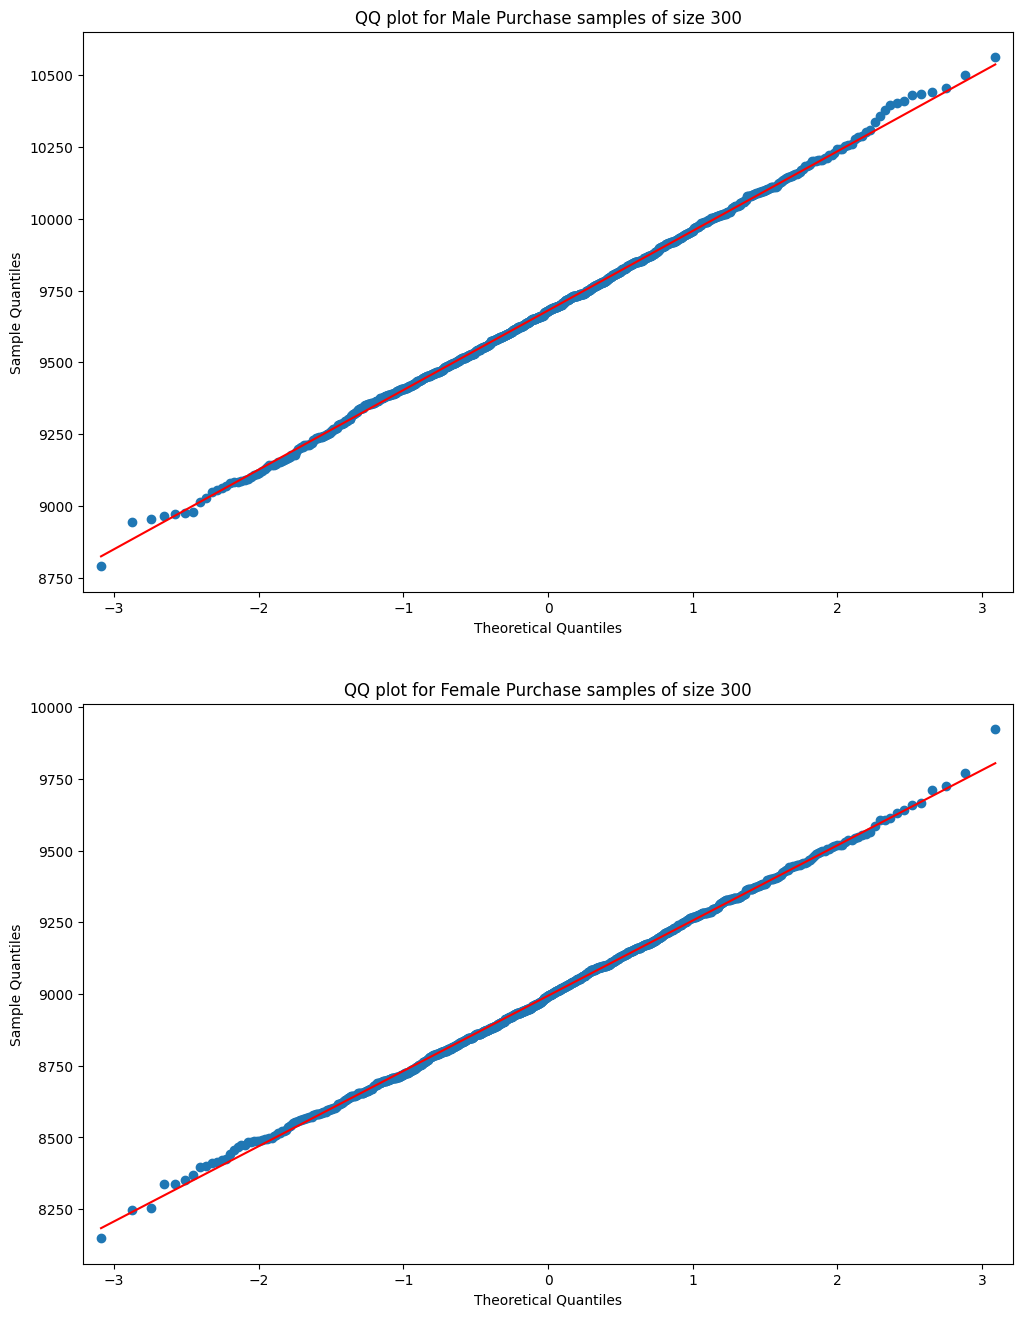

In [291]:
# Checking Gaussian distribution for the samples
fig, ax = plt.subplots(2, 1, figsize=(12, 16))
ax[0].set_title("QQ plot for Male Purchase samples of size 300")
qqplot(np.array(male_sample_means_300), line='s', ax=ax[0])
ax[1].set_title("QQ plot for Female Purchase samples of size 300")
qqplot(np.array(female_sample_means_300), line='s', ax=ax[1])
plt.show()

> Since the points overlap and intersect the central line, this indicates  that the distribution is Gaussian. Thus, satifying all conditions for applying CLT. 

Now we can compute the confidence interval for the sample means

In [296]:
# Confidence Interval at 95% for Male Purchase Samples of size 300
standard_error = male_df["Purchase"].std() / np.sqrt(300)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(male_sample_means_300) - margin_of_error
upper_limit = np.mean(male_sample_means_300) + margin_of_error
print(
    f"Confidence Intervals for Male Purchase Samples of size 300: ({lower_limit}, {upper_limit})")  

# Confidence Interval at 95% for female Purchase Samples of size 300
standard_error = female_df["Purchase"].std() / np.sqrt(300)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(female_sample_means_300) - margin_of_error
upper_limit = np.mean(female_sample_means_300) + margin_of_error
print(
    f"Confidence Intervals for female Purchase Samples of size 300: ({lower_limit}, {upper_limit})")

Confidence Intervals for Male Purchase Samples of size 300: (9221.469295592422, 10140.279084407575)
Confidence Intervals for female Purchase Samples of size 300: (8566.587871018291, 9421.374055648372)


> Since there is an overlap between the lower CI and upper CI for Male and Female Purchase samples, we can not confirm if Men spend more than females with 95% confidence and vice-versa for a sample size of 300.

***Analysis of Purchases over Gender Category with a Sample size of 3000***

In [297]:
male_df = df[df["Gender"] == "M"]
female_df = df[df["Gender"] == "F"]

# Gender-wise purchase sample of 3000
male_sample_means_3000 = generate_purchase_means_from_samples(male_df, 3000)
female_sample_means_3000 = generate_purchase_means_from_samples(female_df, 3000)

In [298]:
# Sample Purchase means comparison with population mean
print("Male population mean: ", male_df["Purchase"].mean())
print("Male Sample mean: ", np.mean(male_sample_means_3000))
print("Female population mean: ", female_df["Purchase"].mean())
print("Female Sample mean: ", np.mean(female_sample_means_3000))

Male population mean:  9678.938244619645
Male Sample mean:  9677.8956
Female population mean:  8997.128082687657
Female Sample mean:  8998.255394000002


> The above comparison of population and sample means satisfies the condition: ***The means of sample should be approx. close to the populations mean***

Now we check if it satifies the second condition of the sample means displaying a Gaussian distribution

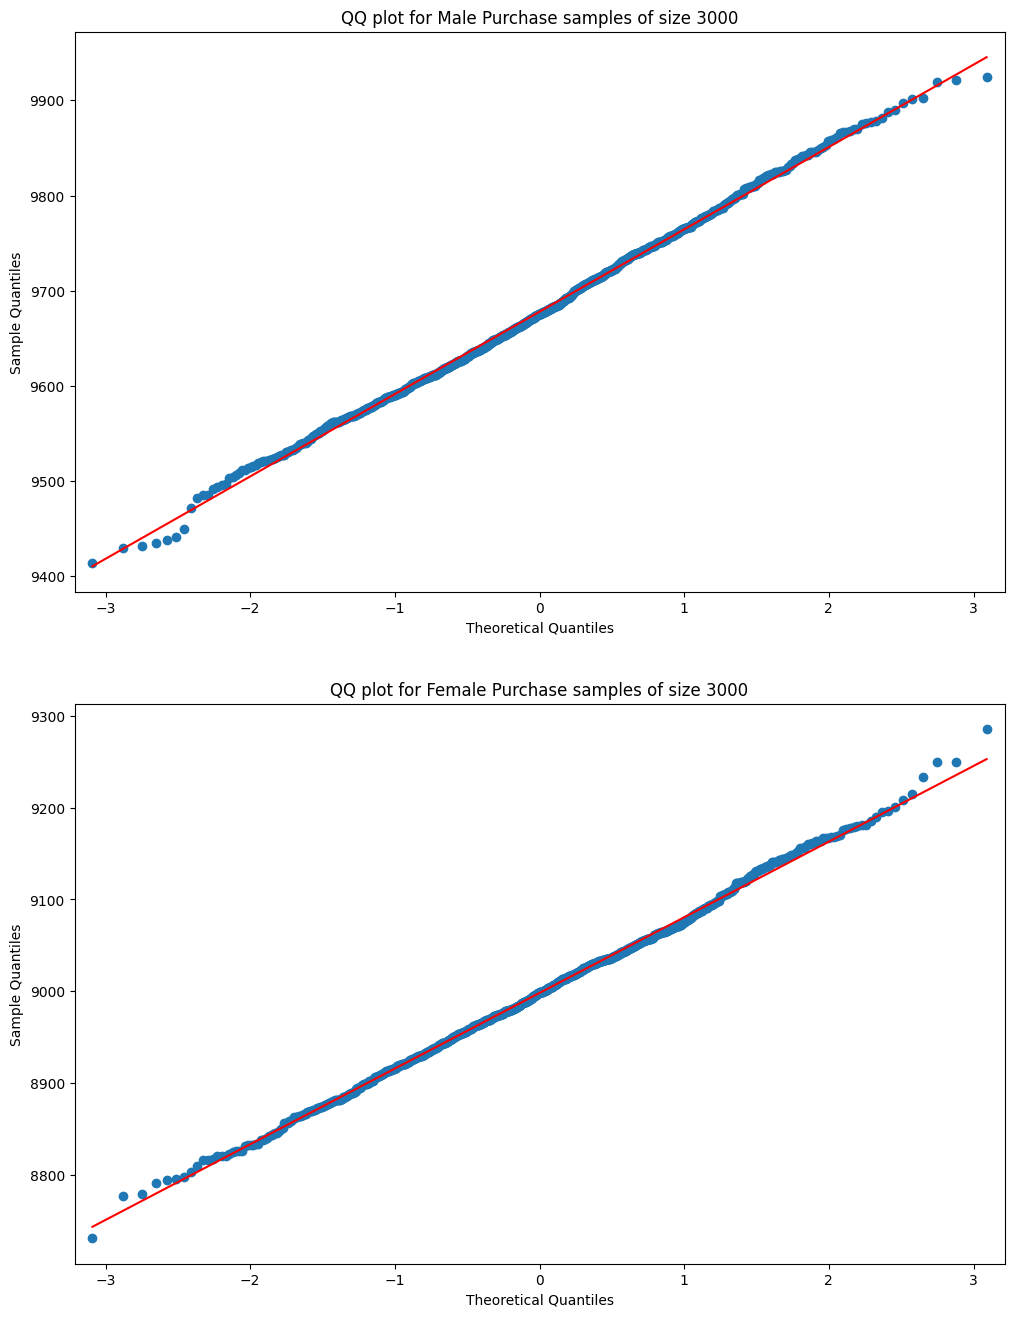

In [299]:
# Checking Gaussian distribution for the samples
fig, ax = plt.subplots(2, 1, figsize=(12, 16))
ax[0].set_title("QQ plot for Male Purchase samples of size 3000")
qqplot(np.array(male_sample_means_3000), line='s', ax=ax[0])
ax[1].set_title("QQ plot for Female Purchase samples of size 3000")
qqplot(np.array(female_sample_means_3000), line='s', ax=ax[1])
plt.show()

> Since the points overlap and intersect the central line, this indicates  that the distribution is Gaussian. Thus, satifying all conditions for applying CLT. 

Now we can compute the confidence interval for the sample means

In [300]:
# Confidence Interval at 95% for Male Purchase Samples of size 3000
standard_error = male_df["Purchase"].std() / np.sqrt(3000)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(male_sample_means_3000) - margin_of_error
upper_limit = np.mean(male_sample_means_3000) + margin_of_error
print(
    f"Confidence Intervals for Male Purchase Samples of size 3000: ({lower_limit}, {upper_limit})")  

# Confidence Interval at 95% for female Purchase Samples of size 3000
standard_error = female_df["Purchase"].std() / np.sqrt(3000)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(female_sample_means_3000) - margin_of_error
upper_limit = np.mean(female_sample_means_3000) + margin_of_error
print(
    f"Confidence Intervals for female Purchase Samples of size 3000: ({lower_limit}, {upper_limit})")

Confidence Intervals for Male Purchase Samples of size 3000: (9532.61901654429, 9823.17218345571)
Confidence Intervals for female Purchase Samples of size 3000: (8863.101831206188, 9133.408956793815)


> Since there is no overlap between the lower CI and upper CI for Male and Female Purchase samples, we can confirm with 95% confidence that Men spend more than females.

***Analysis of Purchases over Gender Category with a Sample size of 30000***

In [301]:
male_df = df[df["Gender"] == "M"]
female_df = df[df["Gender"] == "F"]

# Gender-wise purchase sample of 30000
male_sample_means_30000 = generate_purchase_means_from_samples(male_df, 30000)
female_sample_means_30000 = generate_purchase_means_from_samples(female_df, 30000)

In [302]:
# Sample Purchase means comparison with population mean
print("Male population mean: ", male_df["Purchase"].mean())
print("Male Sample mean: ", np.mean(male_sample_means_30000))
print("Female population mean: ", female_df["Purchase"].mean())
print("Female Sample mean: ", np.mean(female_sample_means_30000))

Male population mean:  9678.938244619645
Male Sample mean:  9678.445557466666
Female population mean:  8997.128082687657
Female Sample mean:  8997.001337433334


> The above comparison of population and sample means satisfies the condition: ***The means of sample should be approx. close to the populations mean***

Now we check if it satifies the second condition of the sample means displaying a Gaussian distribution

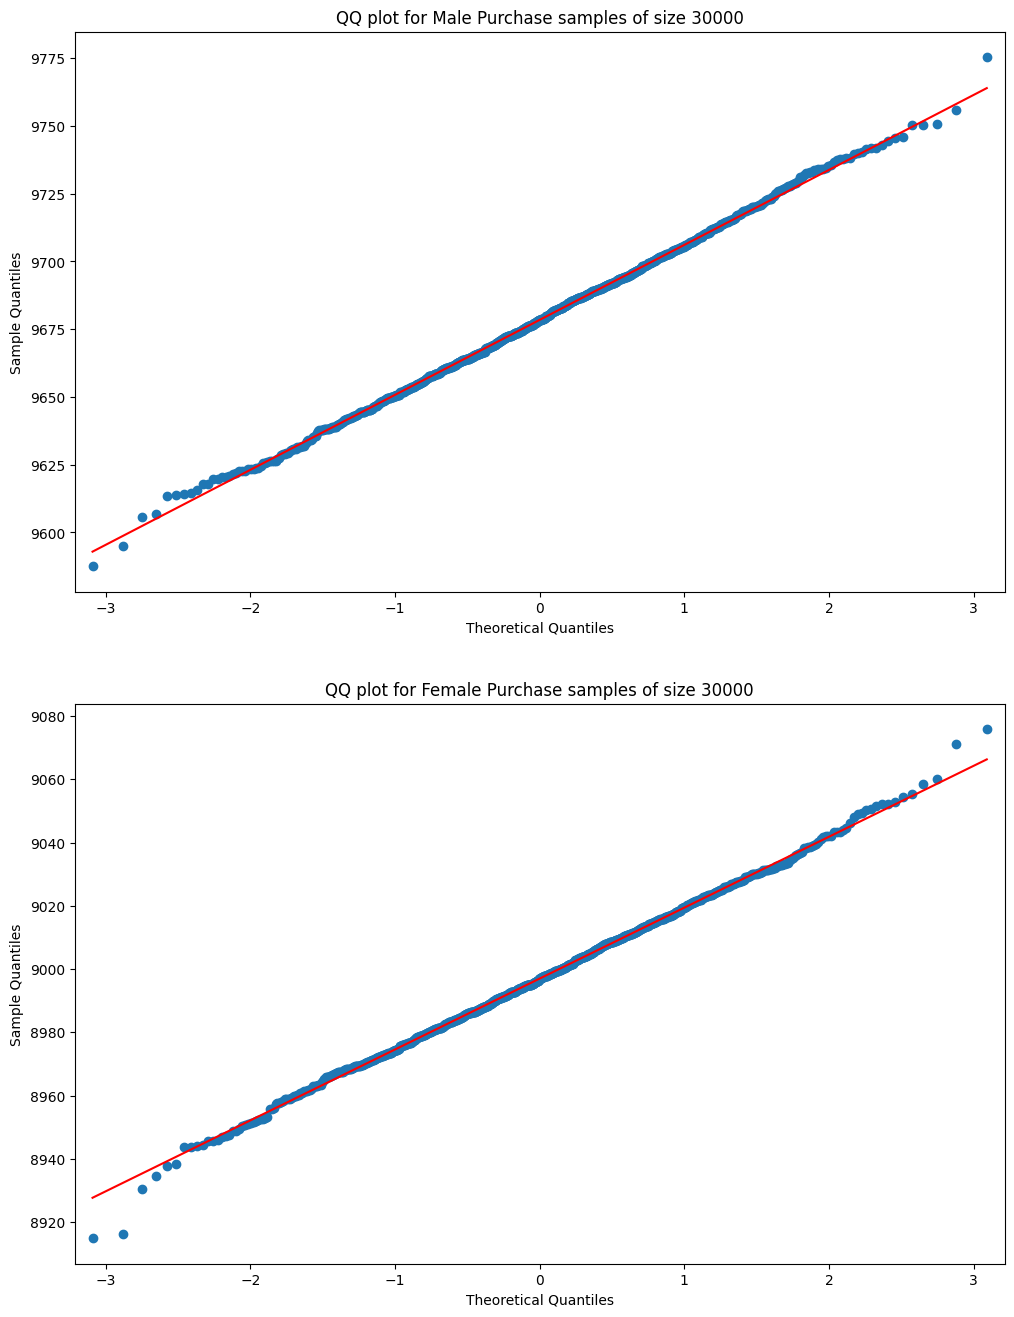

In [303]:
# Checking Gaussian distribution for the samples
fig, ax = plt.subplots(2, 1, figsize=(12, 16))
ax[0].set_title("QQ plot for Male Purchase samples of size 30000")
qqplot(np.array(male_sample_means_30000), line='s', ax=ax[0])
ax[1].set_title("QQ plot for Female Purchase samples of size 30000")
qqplot(np.array(female_sample_means_30000), line='s', ax=ax[1])
plt.show()

> Since the points overlap and intersect the central line, this indicates  that the distribution is Gaussian. Thus, satifying all conditions for applying CLT. 

Now we can compute the confidence interval for the sample means

In [304]:
# Confidence Interval at 95% for Male Purchase Samples of size 30000
standard_error = male_df["Purchase"].std() / np.sqrt(30000)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(male_sample_means_30000) - margin_of_error
upper_limit = np.mean(male_sample_means_30000) + margin_of_error
print(
    f"Confidence Intervals for Male Purchase Samples of size 30000: ({lower_limit}, {upper_limit})")  

# Confidence Interval at 95% for female Purchase Samples of size 30000
standard_error = female_df["Purchase"].std() / np.sqrt(30000)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(female_sample_means_30000) - margin_of_error
upper_limit = np.mean(female_sample_means_30000) + margin_of_error
print(
    f"Confidence Intervals for female Purchase Samples of size 30000: ({lower_limit}, {upper_limit})")

Confidence Intervals for Male Purchase Samples of size 30000: (9632.505068025908, 9724.386046907424)
Confidence Intervals for female Purchase Samples of size 30000: (8954.26202820183, 9039.740646664837)


> Since there is no overlap between the lower CI and upper CI for Male and Female Purchase samples, we can confirm with 95% confidence that male customers spend more than female customers

***Analysis of Purchases over Marital Status with a Sample size of 300***

In [305]:
married_df = df[df["Marital_Status"] == True]
unmarried_df = df[df["Marital_Status"] == False]

# Marital_Status-wise purchase sample of 300
married_sample_means_300 = generate_purchase_means_from_samples(married_df, 300)
unmarried_sample_means_300 = generate_purchase_means_from_samples(unmarried_df, 300)

In [306]:
# Sample Purchase means comparison with population mean
print("Married population mean: ", married_df["Purchase"].mean())
print("Married Sample mean: ", np.mean(married_sample_means_300))
print("Unmarried population mean: ", unmarried_df["Purchase"].mean())
print("Unmarried Sample mean: ", np.mean(unmarried_sample_means_300))

Married population mean:  9516.38225113641
Married Sample mean:  9523.202986666667
Unmarried population mean:  9507.671884864236
Unmarried Sample mean:  9501.267426666665


> The above comparison of population and sample means satisfies the condition: ***The means of sample should be approx. close to the populations mean***

Now we check if it satifies the second condition of the sample means displaying a Gaussian distribution

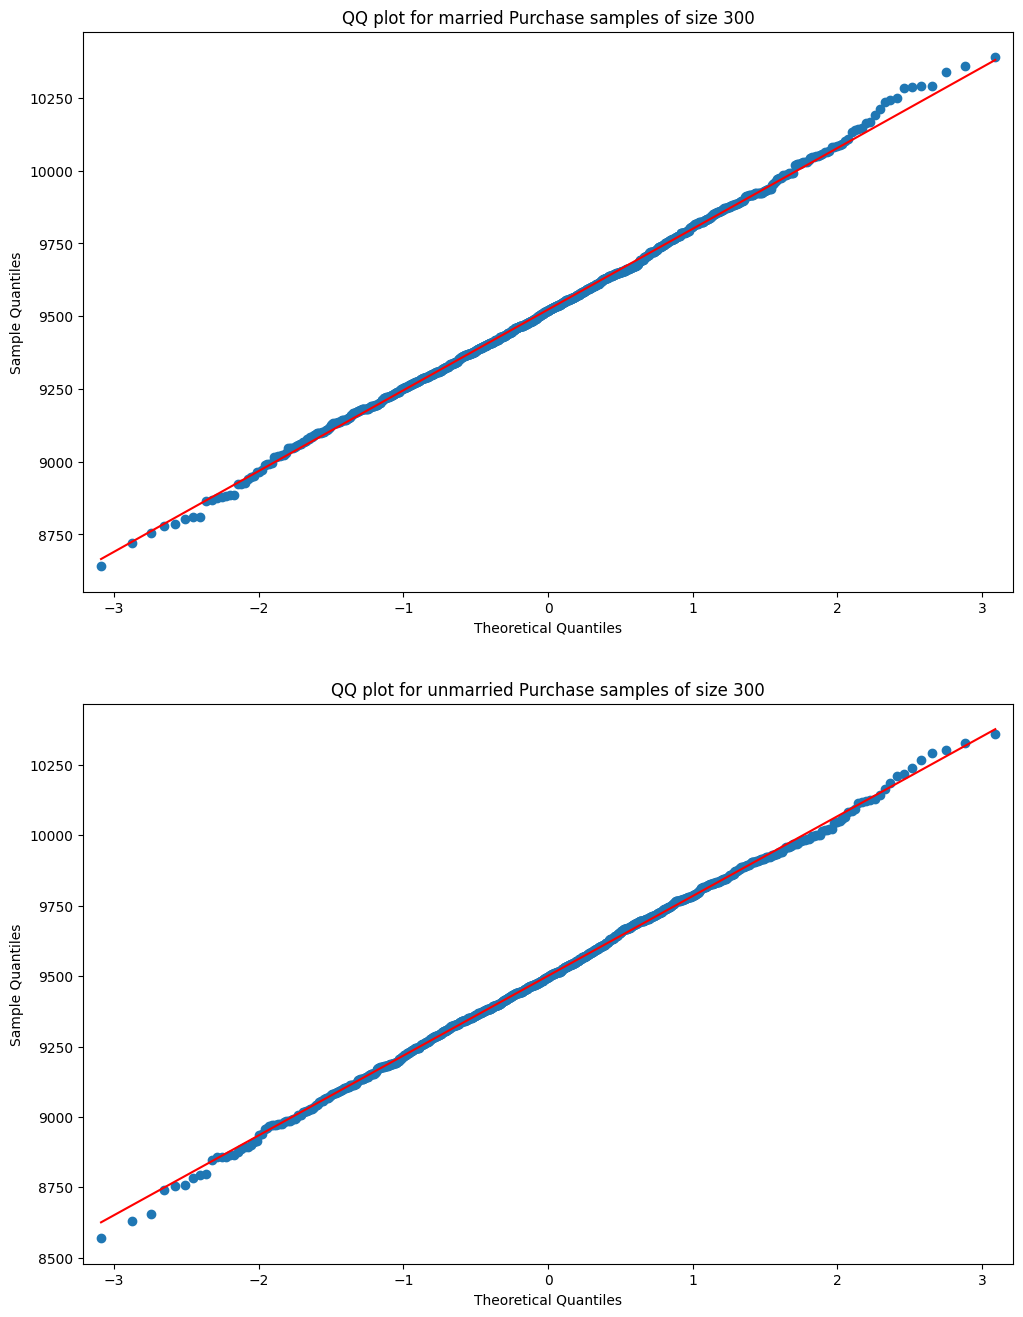

In [307]:
# Checking Gaussian distribution for the samples
fig, ax = plt.subplots(2, 1, figsize=(12, 16))
ax[0].set_title("QQ plot for married Purchase samples of size 300")
qqplot(np.array(married_sample_means_300), line='s', ax=ax[0])
ax[1].set_title("QQ plot for unmarried Purchase samples of size 300")
qqplot(np.array(unmarried_sample_means_300), line='s', ax=ax[1])
plt.show()

> Since the points overlap and intersect the central line, this indicates  that the distribution is Gaussian. Thus, satifying all conditions for applying CLT. 

Now we can compute the confidence interval for the sample means

In [308]:
# Confidence Interval at 95% for married Purchase Samples of size 300
standard_error = married_df["Purchase"].std() / np.sqrt(300)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(married_sample_means_300) - margin_of_error
upper_limit = np.mean(married_sample_means_300) + margin_of_error
print(
    f"Confidence Intervals for married Purchase Samples of size 300: ({lower_limit}, {upper_limit})")  

# Confidence Interval at 95% for femarried Purchase Samples of size 300
standard_error = unmarried_df["Purchase"].std() / np.sqrt(300)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(unmarried_sample_means_300) - margin_of_error
upper_limit = np.mean(unmarried_sample_means_300) + margin_of_error
print(
    f"Confidence Intervals for femarried Purchase Samples of size 300: ({lower_limit}, {upper_limit})")

Confidence Intervals for married Purchase Samples of size 300: (9072.669070170577, 9973.736903162757)
Confidence Intervals for femarried Purchase Samples of size 300: (9047.242350740387, 9955.292502592943)


> Since there is a clear overlap between the lower CI and upper CI for married and unmarried Purchase samples, we can not confirm if married customers spend more than unmarried customers with 95% confidence and vice-versa for a sample size of 300.

***Analysis of Purchases over Marital Status with a Sample size of 3000***

In [309]:
married_df = df[df["Marital_Status"] == True]
unmarried_df = df[df["Marital_Status"] == False]

# Marital_Status-wise purchase sample of 3000
married_sample_means_3000 = generate_purchase_means_from_samples(married_df, 3000)
unmarried_sample_means_3000 = generate_purchase_means_from_samples(unmarried_df, 3000)

In [310]:
# Sample Purchase means comparison with population mean
print("Married population mean: ", married_df["Purchase"].mean())
print("Married Sample mean: ", np.mean(married_sample_means_3000))
print("Unmarried population mean: ", unmarried_df["Purchase"].mean())
print("Unmarried Sample mean: ", np.mean(unmarried_sample_means_3000))

Married population mean:  9516.38225113641
Married Sample mean:  9514.527192666666
Unmarried population mean:  9507.671884864236
Unmarried Sample mean:  9510.631662


> The above comparison of population and sample means satisfies the condition: ***The means of sample should be approx. close to the populations mean***

Now we check if it satifies the second condition of the sample means displaying a Gaussian distribution

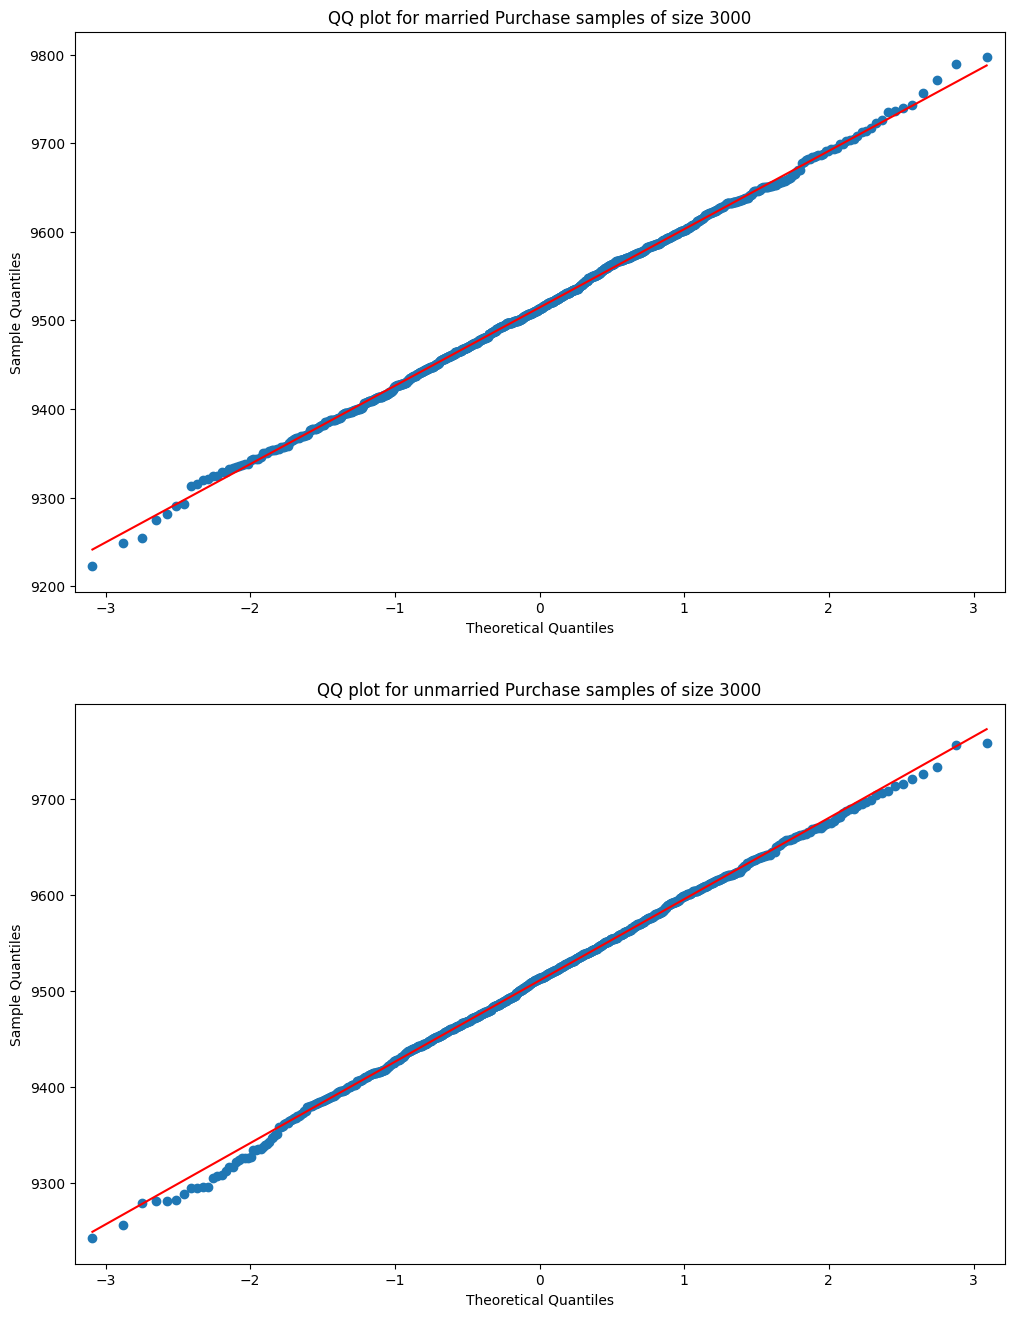

In [311]:
# Checking Gaussian distribution for the samples
fig, ax = plt.subplots(2, 1, figsize=(12, 16))
ax[0].set_title("QQ plot for married Purchase samples of size 3000")
qqplot(np.array(married_sample_means_3000), line='s', ax=ax[0])
ax[1].set_title("QQ plot for unmarried Purchase samples of size 3000")
qqplot(np.array(unmarried_sample_means_3000), line='s', ax=ax[1])
plt.show()

> Since the points overlap and intersect the central line, this indicates  that the distribution is Gaussian. Thus, satifying all conditions for applying CLT. 

Now we can compute the confidence interval for the sample means

In [312]:
# Confidence Interval at 95% for married Purchase Samples of size 3000
standard_error = married_df["Purchase"].std() / np.sqrt(3000)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(married_sample_means_3000) - margin_of_error
upper_limit = np.mean(married_sample_means_3000) + margin_of_error
print(
    f"Confidence Intervals for married Purchase Samples of size 3000: ({lower_limit}, {upper_limit})")  

# Confidence Interval at 95% for femarried Purchase Samples of size 3000
standard_error = unmarried_df["Purchase"].std() / np.sqrt(3000)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(unmarried_sample_means_3000) - margin_of_error
upper_limit = np.mean(unmarried_sample_means_3000) + margin_of_error
print(
    f"Confidence Intervals for femarried Purchase Samples of size 3000: ({lower_limit}, {upper_limit})")

Confidence Intervals for married Purchase Samples of size 3000: (9372.055858738291, 9656.998526595042)
Confidence Intervals for femarried Purchase Samples of size 3000: (9367.056326524207, 9654.206997475792)


> Since there is a clear overlap between the lower CI and upper CI for married and unmarried Purchase samples, we can not confirm if married customers spend more than unmarried customers with 95% confidence and vice-versa for a sample size of 3000.

***Analysis of Purchases over Marital Status with a Sample size of 30000***

In [314]:
married_df = df[df["Marital_Status"] == True]
unmarried_df = df[df["Marital_Status"] == False]

# Marital_Status-wise purchase sample of 30000
married_sample_means_30000 = generate_purchase_means_from_samples(married_df, 30000)
unmarried_sample_means_30000 = generate_purchase_means_from_samples(unmarried_df, 30000)

In [315]:
# Sample Purchase means comparison with population mean
print("Married population mean: ", married_df["Purchase"].mean())
print("Married Sample mean: ", np.mean(married_sample_means_30000))
print("Unmarried population mean: ", unmarried_df["Purchase"].mean())
print("Unmarried Sample mean: ", np.mean(unmarried_sample_means_30000))

Married population mean:  9516.38225113641
Married Sample mean:  9515.289023466665
Unmarried population mean:  9507.671884864236
Unmarried Sample mean:  9508.919949233332


> The above comparison of population and sample means satisfies the condition: ***The means of sample should be approx. close to the populations mean***

Now we check if it satifies the second condition of the sample means displaying a Gaussian distribution

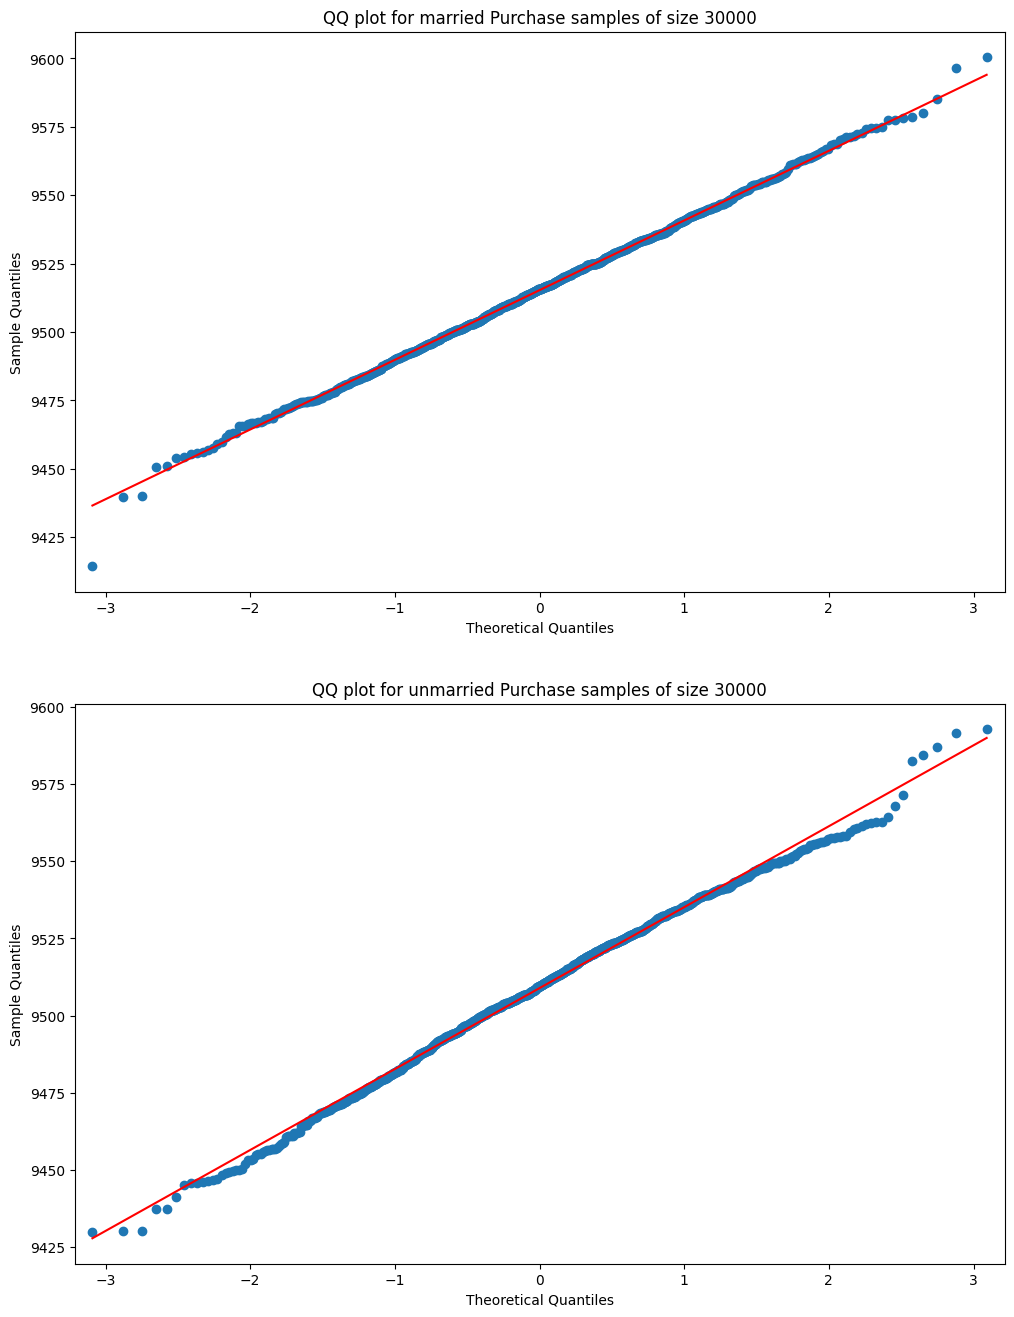

In [316]:
# Checking Gaussian distribution for the samples
fig, ax = plt.subplots(2, 1, figsize=(12, 16))
ax[0].set_title("QQ plot for married Purchase samples of size 30000")
qqplot(np.array(married_sample_means_30000), line='s', ax=ax[0])
ax[1].set_title("QQ plot for unmarried Purchase samples of size 30000")
qqplot(np.array(unmarried_sample_means_30000), line='s', ax=ax[1])
plt.show()

> Since the points overlap and intersect the central line, this indicates  that the distribution is Gaussian. Thus, satifying all conditions for applying CLT. 

Now we can compute the confidence interval for the sample means

In [317]:
# Confidence Interval at 95% for married Purchase Samples of size 30000
standard_error = married_df["Purchase"].std() / np.sqrt(30000)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(married_sample_means_30000) - margin_of_error
upper_limit = np.mean(married_sample_means_30000) + margin_of_error
print(
    f"Confidence Intervals for married Purchase Samples of size 30000: ({lower_limit}, {upper_limit})")  

# Confidence Interval at 95% for femarried Purchase Samples of size 30000
standard_error = unmarried_df["Purchase"].std() / np.sqrt(30000)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(unmarried_sample_means_30000) - margin_of_error
upper_limit = np.mean(unmarried_sample_means_30000) + margin_of_error
print(
    f"Confidence Intervals for femarried Purchase Samples of size 30000: ({lower_limit}, {upper_limit})")

Confidence Intervals for married Purchase Samples of size 30000: (9470.235631817055, 9560.342415116274)
Confidence Intervals for femarried Purchase Samples of size 30000: (9463.517441640704, 9554.32245682596)


> Since there is a clear overlap between the lower CI and upper CI for married and unmarried Purchase samples, we can not confirm if married customers spend more than unmarried customers with 95% confidence and vice-versa for a sample size of 30000.

***Analysis of Purchases over Age Categories with a Sample size of 300***

In [328]:
age_df_0_17 = df[df["Age"] == '0-17']
age_df_over55 = df[df["Age"] == '55+']
age_df_26_35 = df[df["Age"] == '26-35']
age_df_46_50 = df[df["Age"] == '46-50']
age_df_51_55 = df[df["Age"] == '51-55']
age_df_36_45 = df[df["Age"] == '36-45']
age_df_18_25 = df[df["Age"] == '18-25']

# Age-wise purchase sample of 300
sample_means_300_0_17 = generate_purchase_means_from_samples(age_df_0_17, 300)
sample_means_300_over55 = generate_purchase_means_from_samples(age_df_over55, 300)
sample_means_300_26_35 = generate_purchase_means_from_samples(age_df_26_35, 300)
sample_means_300_46_50 = generate_purchase_means_from_samples(age_df_46_50, 300)
sample_means_300_51_55 = generate_purchase_means_from_samples(age_df_51_55, 300)
sample_means_300_36_45 = generate_purchase_means_from_samples(age_df_36_45, 300)
sample_means_300_18_25 = generate_purchase_means_from_samples(age_df_18_25, 300)

In [329]:
# Sample Purchase means comparison with population mean
print("Age group 0-17 population mean: ", age_df_0_17["Purchase"].mean())
print("Age group 0-17 Sample mean: ", np.mean(sample_means_300_0_17))
print('-'*50)
print("Age group 18-25 population mean: ", age_df_18_25["Purchase"].mean())
print("Age group 18-25 Sample mean: ", np.mean(sample_means_300_18_25))
print('-'*50)
print("Age group 26-35 population mean: ", age_df_26_35["Purchase"].mean())
print("Age group 26-35 Sample mean: ", np.mean(sample_means_300_26_35))
print('-'*50)
print("Age group 36-45 population mean: ", age_df_36_45["Purchase"].mean())
print("Age group 36-45 Sample mean: ", np.mean(sample_means_300_36_45))
print('-'*50)
print("Age group 46-50 population mean: ", age_df_46_50["Purchase"].mean())
print("Age group 46-50 Sample mean: ", np.mean(sample_means_300_46_50))
print('-'*50)
print("Age group 51-55 population mean: ", age_df_51_55["Purchase"].mean())
print("Age group 51-55 Sample mean: ", np.mean(sample_means_300_51_55))
print('-'*50)
print("Age group 55+ population mean: ", age_df_over55["Purchase"].mean())
print("Age group 55+ Sample mean: ", np.mean(sample_means_300_over55))

Age group 0-17 population mean:  9272.180961028076
Age group 0-17 Sample mean:  9270.715106666665
--------------------------------------------------
Age group 18-25 population mean:  9425.805827165641
Age group 18-25 Sample mean:  9436.749603333334
--------------------------------------------------
Age group 26-35 population mean:  9473.008766957639
Age group 26-35 Sample mean:  9455.449773333334
--------------------------------------------------
Age group 36-45 population mean:  9582.32692709223
Age group 36-45 Sample mean:  9577.44609
--------------------------------------------------
Age group 46-50 population mean:  9485.307893349229
Age group 46-50 Sample mean:  9480.794629999999
--------------------------------------------------
Age group 51-55 population mean:  9804.103165715222
Age group 51-55 Sample mean:  9812.054973333332
--------------------------------------------------
Age group 55+ population mean:  9640.599694761717
Age group 55+ Sample mean:  9639.250960000001


> The above comparison of population and sample means satisfies the condition: ***The means of sample should be approx. close to the populations mean***

Now we check if it satifies the second condition of the sample means displaying a Gaussian distribution

In [332]:
# Checking Gaussian distribution for the samples using Shaprio Wilk's Normality Test
_, p = shapiro(sample_means_300_0_17)
if p > 0.05:
    print("Age Category 0_17 Distribution Probably Gaussian")
    print("-"*50)
else:
    print("0_17 Age Category probably not Gaussian")
    print("="*50)
_, p = shapiro(sample_means_300_18_25)
if p > 0.05:
    print("Age Category 18_25 Distribution Probably Gaussian")
    print("-"*50)
else:
    print("18_25 Age Category probably not Gaussian")
    print("="*50)
_, p = shapiro(sample_means_300_26_35)
if p > 0.05:
    print("Age Category 26_35 Distribution Probably Gaussian")
    print("-"*50)
else:
    print("26_35 Age Category probably not Gaussian")
    print("="*50)
_, p = shapiro(sample_means_300_36_45)
if p > 0.05:
    print("Age Category 36_45 Distribution Probably Gaussian")
    print("-"*50)
else:
    print("36_45 Age Category probably not Gaussian")
    print("="*50)
_, p = shapiro(sample_means_300_46_50)
if p > 0.05:
    print("Age Category 46_50 Distribution Probably Gaussian")
    print("-"*50)
else:
    print("46_50 Age Category probably not Gaussian")
    print("="*50)
_, p = shapiro(sample_means_300_51_55)
if p > 0.05:
    print("Age Category 51_55 Distribution Probably Gaussian")
    print("-"*50)
else:
    print("51_55 Age Category probably not Gaussian")
    print("="*50)
_, p = shapiro(sample_means_300_over55)
if p > 0.05:
    print("Age Category over55 Distribution Probably Gaussian")
    print("-"*50)
else:
    print("over55 Age Category probably not Gaussian")
    print("="*50)

Age Category 0_17 Distribution Probably Gaussian
--------------------------------------------------
Age Category 18_25 Distribution Probably Gaussian
--------------------------------------------------
Age Category 26_35 Distribution Probably Gaussian
--------------------------------------------------
Age Category 36_45 Distribution Probably Gaussian
--------------------------------------------------
Age Category 46_50 Distribution Probably Gaussian
--------------------------------------------------
Age Category 51_55 Distribution Probably Gaussian
--------------------------------------------------
Age Category over55 Distribution Probably Gaussian
--------------------------------------------------


> Since all Age categories are probably Gaussian, this satisfies all conditions for applying CLT. 

Now we can compute the confidence interval for the sample means

In [333]:
# Confidence Interval at 95% for age group 0-17 Purchase Samples of size 300
standard_error = age_df_0_17["Purchase"].std() / np.sqrt(300)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(sample_means_300_0_17) - margin_of_error
upper_limit = np.mean(sample_means_300_0_17) + margin_of_error
print(
    f"Confidence Intervals for age group 0-17 Purchase Samples of size 300: ({lower_limit}, {upper_limit})")
print("-"*100)

# Confidence Interval at 95% for age group 18-25 Purchase Samples of size 300
standard_error = age_df_18_25["Purchase"].std() / np.sqrt(300)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(sample_means_300_18_25) - margin_of_error
upper_limit = np.mean(sample_means_300_18_25) + margin_of_error
print(
    f"Confidence Intervals for age group 18-25 Purchase Samples of size 300: ({lower_limit}, {upper_limit})")
print("-"*100)

# Confidence Interval at 95% for age group 26-35 Purchase Samples of size 300
standard_error = age_df_26_35["Purchase"].std() / np.sqrt(300)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(sample_means_300_26_35) - margin_of_error
upper_limit = np.mean(sample_means_300_26_35) + margin_of_error
print(
    f"Confidence Intervals for age group 26-35 Purchase Samples of size 300: ({lower_limit}, {upper_limit})")
print("-"*100)

# Confidence Interval at 95% for age group 36_45 Purchase Samples of size 300
standard_error = age_df_36_45["Purchase"].std() / np.sqrt(300)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(sample_means_300_36_45) - margin_of_error
upper_limit = np.mean(sample_means_300_36_45) + margin_of_error
print(
    f"Confidence Intervals for age group 36_45 Purchase Samples of size 300: ({lower_limit}, {upper_limit})")
print("-"*100)

# Confidence Interval at 95% for age group 46-50 Purchase Samples of size 300
standard_error = age_df_46_50["Purchase"].std() / np.sqrt(300)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(sample_means_300_46_50) - margin_of_error
upper_limit = np.mean(sample_means_300_46_50) + margin_of_error
print(
    f"Confidence Intervals for age group 46-50 Purchase Samples of size 300: ({lower_limit}, {upper_limit})")
print("-"*100)

# Confidence Interval at 95% for age group 51-55 Purchase Samples of size 300
standard_error = age_df_51_55["Purchase"].std() / np.sqrt(300)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(sample_means_300_51_55) - margin_of_error
upper_limit = np.mean(sample_means_300_51_55) + margin_of_error
print(
    f"Confidence Intervals for age group 51-55 Purchase Samples of size 300: ({lower_limit}, {upper_limit})")
print("-"*100)

# Confidence Interval at 95% for age group 55+ Purchase Samples of size 300
standard_error = age_df_over55["Purchase"].std() / np.sqrt(300)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(sample_means_300_over55) - margin_of_error
upper_limit = np.mean(sample_means_300_over55) + margin_of_error
print(
    f"Confidence Intervals for age group 55+ Purchase Samples of size 300: ({lower_limit}, {upper_limit})")

Confidence Intervals for age group 0-17 Purchase Samples of size 300: (8811.66792866109, 9729.762284672239)
----------------------------------------------------------------------------------------------------
Confidence Intervals for age group 18-25 Purchase Samples of size 300: (8978.801072212535, 9894.698134454133)
----------------------------------------------------------------------------------------------------
Confidence Intervals for age group 26-35 Purchase Samples of size 300: (9001.05341345592, 9909.846133210747)
----------------------------------------------------------------------------------------------------
Confidence Intervals for age group 36_45 Purchase Samples of size 300: (9127.142225305965, 10027.749954694034)
----------------------------------------------------------------------------------------------------
Confidence Intervals for age group 46-50 Purchase Samples of size 300: (9037.296170777803, 9924.293089222194)
------------------------------------------------

> Since there is a clear overlap between the lower CI and upper CI for age group Purchase samples, we can not confirm if either customers belonging to those age groups with 95% confidence for a sample size of 300.

***Analysis of Purchases over Age Categories with a Sample size of 3000***

In [334]:
age_df_0_17 = df[df["Age"] == '0-17']
age_df_over55 = df[df["Age"] == '55+']
age_df_26_35 = df[df["Age"] == '26-35']
age_df_46_50 = df[df["Age"] == '46-50']
age_df_51_55 = df[df["Age"] == '51-55']
age_df_36_45 = df[df["Age"] == '36-45']
age_df_18_25 = df[df["Age"] == '18-25']

# Age-wise purchase sample of 3000
sample_means_3000_0_17 = generate_purchase_means_from_samples(age_df_0_17, 3000)
sample_means_3000_over55 = generate_purchase_means_from_samples(age_df_over55, 3000)
sample_means_3000_26_35 = generate_purchase_means_from_samples(age_df_26_35, 3000)
sample_means_3000_46_50 = generate_purchase_means_from_samples(age_df_46_50, 3000)
sample_means_3000_51_55 = generate_purchase_means_from_samples(age_df_51_55, 3000)
sample_means_3000_36_45 = generate_purchase_means_from_samples(age_df_36_45, 3000)
sample_means_3000_18_25 = generate_purchase_means_from_samples(age_df_18_25, 3000)

In [335]:
# Sample Purchase means comparison with population mean
print("Age group 0-17 population mean: ", age_df_0_17["Purchase"].mean())
print("Age group 0-17 Sample mean: ", np.mean(sample_means_3000_0_17))
print('-'*50)
print("Age group 18-25 population mean: ", age_df_18_25["Purchase"].mean())
print("Age group 18-25 Sample mean: ", np.mean(sample_means_3000_18_25))
print('-'*50)
print("Age group 26-35 population mean: ", age_df_26_35["Purchase"].mean())
print("Age group 26-35 Sample mean: ", np.mean(sample_means_3000_26_35))
print('-'*50)
print("Age group 36-45 population mean: ", age_df_36_45["Purchase"].mean())
print("Age group 36-45 Sample mean: ", np.mean(sample_means_3000_36_45))
print('-'*50)
print("Age group 46-50 population mean: ", age_df_46_50["Purchase"].mean())
print("Age group 46-50 Sample mean: ", np.mean(sample_means_3000_46_50))
print('-'*50)
print("Age group 51-55 population mean: ", age_df_51_55["Purchase"].mean())
print("Age group 51-55 Sample mean: ", np.mean(sample_means_3000_51_55))
print('-'*50)
print("Age group 55+ population mean: ", age_df_over55["Purchase"].mean())
print("Age group 55+ Sample mean: ", np.mean(sample_means_3000_over55))

Age group 0-17 population mean:  9272.180961028076
Age group 0-17 Sample mean:  9270.824762333334
--------------------------------------------------
Age group 18-25 population mean:  9425.805827165641
Age group 18-25 Sample mean:  9426.679074000001
--------------------------------------------------
Age group 26-35 population mean:  9473.008766957639
Age group 26-35 Sample mean:  9469.199945333334
--------------------------------------------------
Age group 36-45 population mean:  9582.32692709223
Age group 36-45 Sample mean:  9578.966448333334
--------------------------------------------------
Age group 46-50 population mean:  9485.307893349229
Age group 46-50 Sample mean:  9486.416762666668
--------------------------------------------------
Age group 51-55 population mean:  9804.103165715222
Age group 51-55 Sample mean:  9803.954664333332
--------------------------------------------------
Age group 55+ population mean:  9640.599694761717
Age group 55+ Sample mean:  9640.612908


> The above comparison of population and sample means satisfies the condition: ***The means of sample should be approx. close to the populations mean***

Now we check if it satifies the second condition of the sample means displaying a Gaussian distribution

In [336]:
# Checking Gaussian distribution for the samples using Shaprio Wilk's Normality Test
_, p = shapiro(sample_means_3000_0_17)
if p > 0.05:
    print("Age Category 0_17 Distribution Probably Gaussian")
    print("-"*50)
else:
    print("0_17 Age Category probably not Gaussian")
    print("="*50)
_, p = shapiro(sample_means_3000_18_25)
if p > 0.05:
    print("Age Category 18_25 Distribution Probably Gaussian")
    print("-"*50)
else:
    print("18_25 Age Category probably not Gaussian")
    print("="*50)
_, p = shapiro(sample_means_3000_26_35)
if p > 0.05:
    print("Age Category 26_35 Distribution Probably Gaussian")
    print("-"*50)
else:
    print("26_35 Age Category probably not Gaussian")
    print("="*50)
_, p = shapiro(sample_means_3000_36_45)
if p > 0.05:
    print("Age Category 36_45 Distribution Probably Gaussian")
    print("-"*50)
else:
    print("36_45 Age Category probably not Gaussian")
    print("="*50)
_, p = shapiro(sample_means_3000_46_50)
if p > 0.05:
    print("Age Category 46_50 Distribution Probably Gaussian")
    print("-"*50)
else:
    print("46_50 Age Category probably not Gaussian")
    print("="*50)
_, p = shapiro(sample_means_3000_51_55)
if p > 0.05:
    print("Age Category 51_55 Distribution Probably Gaussian")
    print("-"*50)
else:
    print("51_55 Age Category probably not Gaussian")
    print("="*50)
_, p = shapiro(sample_means_3000_over55)
if p > 0.05:
    print("Age Category over55 Distribution Probably Gaussian")
    print("-"*50)
else:
    print("over55 Age Category probably not Gaussian")
    print("="*50)

Age Category 0_17 Distribution Probably Gaussian
--------------------------------------------------
Age Category 18_25 Distribution Probably Gaussian
--------------------------------------------------
Age Category 26_35 Distribution Probably Gaussian
--------------------------------------------------
Age Category 36_45 Distribution Probably Gaussian
--------------------------------------------------
46_50 Age Category probably not Gaussian
Age Category 51_55 Distribution Probably Gaussian
--------------------------------------------------
over55 Age Category probably not Gaussian


> Since the Age groups 46-50 and over 55 categories don't follow a Gaussian distribution, we can not apply CLT for them. However, the other categories satisfy all the conditions. Hence, we'll continue applying CLT for those. 

We can compute the confidence interval for the sample means

In [338]:
# Confidence Interval at 95% for age group 0-17 Purchase Samples of size 3000
standard_error = age_df_0_17["Purchase"].std() / np.sqrt(3000)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(sample_means_3000_0_17) - margin_of_error
upper_limit = np.mean(sample_means_3000_0_17) + margin_of_error
print(
    f"Confidence Intervals for age group 0-17 Purchase Samples of size 3000: ({lower_limit}, {upper_limit})")
print("-"*100)

# Confidence Interval at 95% for age group 18-25 Purchase Samples of size 3000
standard_error = age_df_18_25["Purchase"].std() / np.sqrt(3000)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(sample_means_3000_18_25) - margin_of_error
upper_limit = np.mean(sample_means_3000_18_25) + margin_of_error
print(
    f"Confidence Intervals for age group 18-25 Purchase Samples of size 3000: ({lower_limit}, {upper_limit})")
print("-"*100)

# Confidence Interval at 95% for age group 26-35 Purchase Samples of size 3000
standard_error = age_df_26_35["Purchase"].std() / np.sqrt(3000)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(sample_means_3000_26_35) - margin_of_error
upper_limit = np.mean(sample_means_3000_26_35) + margin_of_error
print(
    f"Confidence Intervals for age group 26-35 Purchase Samples of size 3000: ({lower_limit}, {upper_limit})")
print("-"*100)

# Confidence Interval at 95% for age group 36_45 Purchase Samples of size 3000
standard_error = age_df_36_45["Purchase"].std() / np.sqrt(3000)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(sample_means_3000_36_45) - margin_of_error
upper_limit = np.mean(sample_means_3000_36_45) + margin_of_error
print(
    f"Confidence Intervals for age group 36_45 Purchase Samples of size 3000: ({lower_limit}, {upper_limit})")
print("-"*100)

# Confidence Interval at 95% for age group 51-55 Purchase Samples of size 3000
standard_error = age_df_51_55["Purchase"].std() / np.sqrt(3000)
z_score = norm.ppf(0.95)
margin_of_error = z_score * standard_error
lower_limit = np.mean(sample_means_3000_51_55) - margin_of_error
upper_limit = np.mean(sample_means_3000_51_55) + margin_of_error
print(
    f"Confidence Intervals for age group 51-55 Purchase Samples of size 3000: ({lower_limit}, {upper_limit})")
print("-"*100)

Confidence Intervals for age group 0-17 Purchase Samples of size 3000: (9125.661298736297, 9415.98822593037)
----------------------------------------------------------------------------------------------------
Confidence Intervals for age group 18-25 Purchase Samples of size 3000: (9281.86303305298, 9571.495114947023)
----------------------------------------------------------------------------------------------------
Confidence Intervals for age group 26-35 Purchase Samples of size 3000: (9325.507199563117, 9612.89269110355)
----------------------------------------------------------------------------------------------------
Confidence Intervals for age group 36_45 Purchase Samples of size 3000: (9436.567863172391, 9721.365033494278)
----------------------------------------------------------------------------------------------------
Confidence Intervals for age group 51-55 Purchase Samples of size 3000: (9661.771624937368, 9946.137703729297)
---------------------------------------------

We can say with 95% confidence that:
- Customers belonging to Age groups 36-45 and 51-55 make more purchases than customers belonging to 0-17 age group.
- Customers belonging to Age group 51-55 make more purchases than the customers belonging to the age groups: 0-17, 18-25 and 26-35

## Findings:
- Most Purchases are done by customers belonging to 51-55 age group 
- Most Purchases are made by Male Customers
- Marital status has No major significance in terms of Purchases made.
- Most Orders original in City belonging to City_Category B
- Most Orders placed belong to the age group 26-35.
- Most Products sold belong to Category 5. 

## Recommendations:
- Male Customers to be more preferred. So advertise more male-centric items like tools, camping gear, barbecueing, etc.
- Send out additional offers for customers aged 50+
- Send out additional offers for Product Categories belonging to Product Categories 1, 5 and 8 as they're the top 3 highest product categories being sold.